# A Comparison of k-Means and k-Medians: Robustness to Cluster Separation
### Author: Daniel Wang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpp
import sklearn.datasets as skds
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import time
import itertools

from kgencenters import KGenCenters # this is the custom class

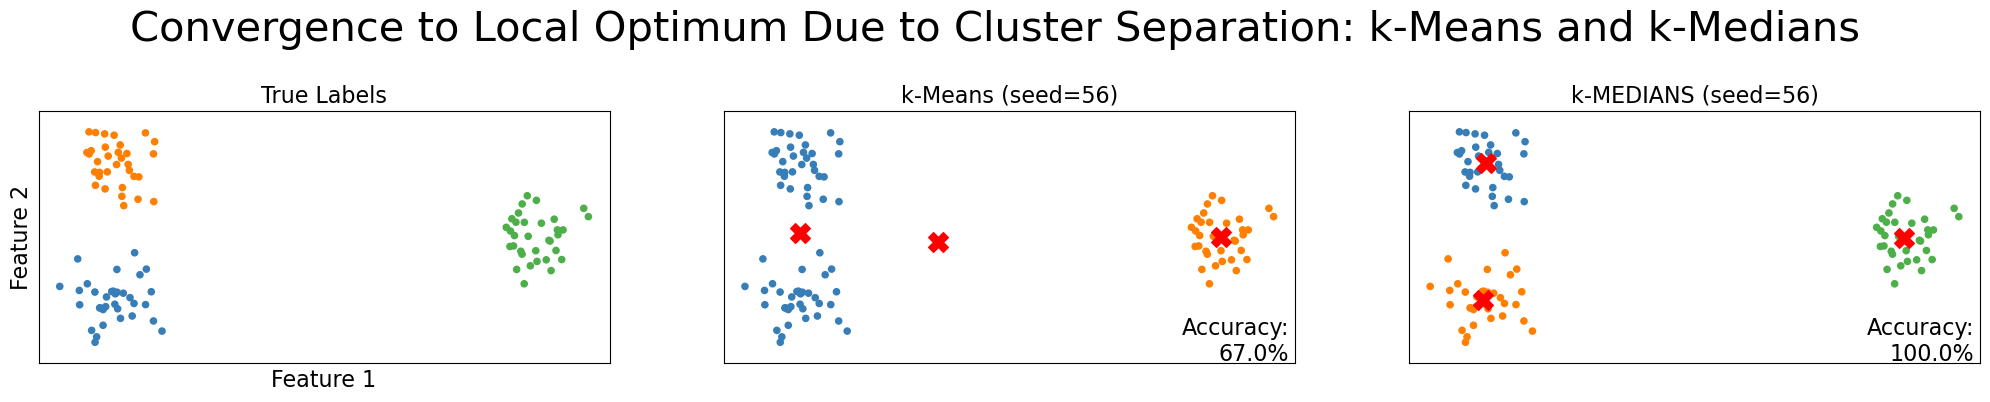

In [2]:
# Generate a synthetic dataset with three blobs
n_samples = 100
centers = [[0, 0], [0, 6], [20, 3]]  # Three main clusters
k = len(centers)
X, y = skds.make_blobs(n_samples=n_samples, centers=centers, random_state=0)

# List of cost metrics
cost_metrics = ['squared_euclidean', 'euclidean']
methods = ['k-Means', 'k-MEDIANS']

# Dictionaries to store labels and centers
label_dict = {}
center_dict = {}

accuracies = []  # Store accuracies for each random seed

seed = int(55)
while True:
    seed += 1
    # Perform k-gencenters clustering for each cost metric
    for cost_metric in cost_metrics:
        # Initialize and fit KGenCenters
        kgencenters = KGenCenters(n_clusters=k, init='random_partition', max_iter=400, random_state=seed, verbose=False)
        kgencenters.fit(X, cost_metric=cost_metric, max_steps=100)

        label_dict[cost_metric] = kgencenters.assigns
        center_dict[cost_metric] = kgencenters.centers

        # Compute confusion matrix
        confusion_matrix = np.zeros((k, k))
        for true_label in range(k):
            for pred_label in range(k):
                confusion_matrix[true_label, pred_label] = np.sum((y == true_label) & (kgencenters.assigns == pred_label))
        
        # Compute optimal assignment using the Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
        
        # Compute accuracy using the optimal assignment
        accuracy = confusion_matrix[row_ind, col_ind].sum() / n_samples
        accuracies.append(accuracy)

    # Check if the difference between accuracies is more than 5%
    if len(accuracies) > 1 and abs(accuracies[-1] - accuracies[-2]) > 0.05:
        break

# Create subplots for each cost metric
fig, axes = plt.subplots(1, len(cost_metrics)+1, figsize=(20, 8))
fig.suptitle("Convergence to Local Optimum Due to Cluster Separation: k-Means and k-Medians", fontsize=30, y=0.75)

# Plot the original data, colored by the true labels
unique_labels = range(k)
colors = np.array(list(itertools.islice(itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']), len(unique_labels))))
axes[0].scatter(X[:, 0], X[:, 1], c=colors[y], s=20)
axes[0].set_title('True Labels', size=16)
axes[0].set_xlabel("Feature 1", fontsize=16)
axes[0].set_ylabel("Feature 2", fontsize=16)
axes[0].set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
axes[0].set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)

# Set common attributes for all subplots
common_attributes = {
    'xticks': [],
    'yticks': [],
    'aspect': 'equal'
}

# Set common attributes using plt.setp()
plt.setp(axes[0], **common_attributes)

# Perform k-gencenters clustering for each cost metric
for i, cost_metric in enumerate(cost_metrics):
    # Define the color scheme
    unique_labels = np.unique(label_dict[cost_metric])
    color_dict = {label: color for label, color in zip(unique_labels, itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']))}

    # Plot the data points and centers
    ax = axes[i+1]
    ax.scatter(X[:, 0], X[:, 1], c=[color_dict[label] for label in label_dict[cost_metric]], s=20)
    ax.scatter(center_dict[cost_metric][:, 0], center_dict[cost_metric][:, 1], marker='X', c='red', s=200, zorder=9)
    ax.set_xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
    ax.set_ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)

    # Set common attributes using plt.setp()
    plt.setp(ax, **common_attributes)

    # Display the accuracy of the labels in the bottom right corner as a percentage
    plt.text(.99, .01, ('Accuracy:\n%.1f%%' % (100*accuracies[-2+i])).lstrip('0'),
                transform=ax.transAxes, size=16, horizontalalignment='right')

    # Set the title based on the cost metric
    ax.set_title(f"{methods[i]} (seed={seed})", size=16)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the spacing between subplots
plt.show()
